In [1]:
from nbodykit.lab import *
import numpy as np
import dask.array as da
from scipy.interpolate import RegularGridInterpolator
import matplotlib.pyplot as plt

import sys
sys.path.append('../general_routines/')
from general_tools import *
from iterative_reconstruction import *

In [2]:
cosmo = cosmology.Planck15

### Import matter catalog
matter = BigFileCatalog('Matter_catalog.bigfile')

# Define global variables
Length = matter.attrs['BoxSize'][0]
Nc = matter.attrs['Nmesh'][0]
zobs = 0.3
zinit = 3.
r_s = 2.*(Length/Nc) # smoothing radius
print('Smoothing radius=', r_s)

# Compute matter density field
delta_dm = matter.to_mesh(resampler='cic', interlaced=True, compensated=True)

# Compute matter P(k,z)
r = FFTPower(delta_dm, mode="1d")
Pkdm = r.power['power'].real - r.power.attrs['shotnoise']
k = r.power['k']

### Import galaxy catalog
galaxy = BigFileCatalog('Galaxy_catalog.bigfile')

# Compute galaxy density field
delta_g = galaxy.to_mesh(resampler='cic', interlaced=True, compensated=True)
delta_gRSD = galaxy.to_mesh(position='PositionRSD', resampler='cic', interlaced=True, compensated=True)
ngal = galaxy.csize

# Compute galaxy P(k,z)
r = FFTPower(delta_g, mode='1d')
Pkg = r.power['power'].real - r.attrs['shotnoise']

r = FFTPower(delta_gRSD, mode='1d')
PkgRSD = r.power['power'].real - r.attrs['shotnoise']

# Calculate bias pre reconstruction
mask = (k <= 0.09)*(k > 0.03)
bg = np.mean(np.sqrt(Pkg[mask]/Pkdm[mask]))
bgRSD = np.mean(np.sqrt(PkgRSD[mask]/Pkdm[mask]))

print('bias (real) PRE= {:.2f} +- {:.2f}'.format(bg, np.std(np.sqrt(Pkg[mask]/Pkdm[mask]))))
print('bias (redshift) PRE= {:.2f} +- {:.2f}'.format(bgRSD, np.std(np.sqrt(PkgRSD[mask]/Pkdm[mask]))))

/home/pdcg/anaconda3/envs/nbodykit-env/lib/python3.6/site-packages/bigfile/__init__.py:358: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  return pyxbigfile.Dataset.__init__(self, file, dtype=dtype, size=size)


Smoothing radius= 7.8125
bias (real) PRE= 1.42 +- 0.01
bias (redshift) PRE= 1.63 +- 0.01


In [4]:
# Valores de formulas (real)
breczinitt = (bg-1)*(D(zobs)/D(zinit)) + 1
breczobst = (bg-1) + (D(zinit)/D(zobs))
print('From real space bias')
print('Expected bias brec(zinit) = {:.2f}'.format(breczinitt))
print('Expected bias brec(zobs) = {:.2f}'.format(breczobst))

# Valores de formulas (redshift)
print('From redshift space bias')
breczinitt = (bgRSD-1)*(D(zobs)/D(zinit)) + 1
breczobst = (bgRSD-1) + (D(zinit)/D(zobs))

print('Expected bias brec(zinit) = {:.2f}'.format(breczinitt))
print('Expected bias brec(zobs) = {:.2f}'.format(breczobst))

From real space bias
Expected bias brec(zinit) = 2.13
Expected bias brec(zobs) = 0.79
From redshift space bias
Expected bias brec(zinit) = 2.71
Expected bias brec(zobs) = 1.01


In [5]:
s = galaxy['PositionRSD'].compute()
mask_high = s>Length
s[mask_high] = Length
mask_low = s<0.
s[mask_low] = 0.
galaxy['PositionRSD'] = s

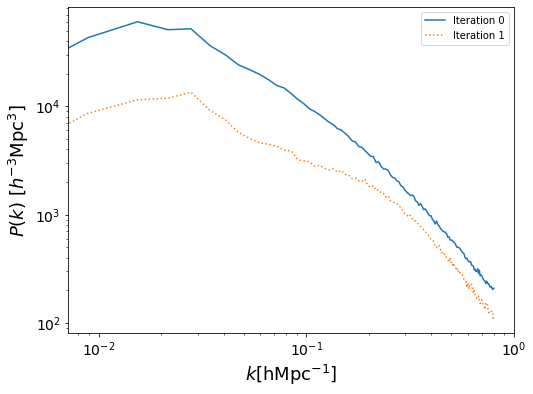

Iteration 1, Mean difference between Pks: 3234.11


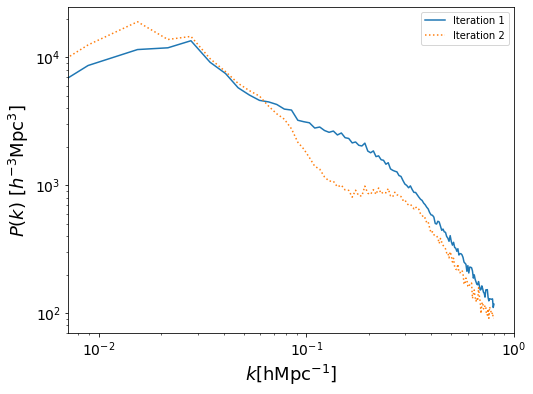

Iteration 2, Mean difference between Pks: 468.37


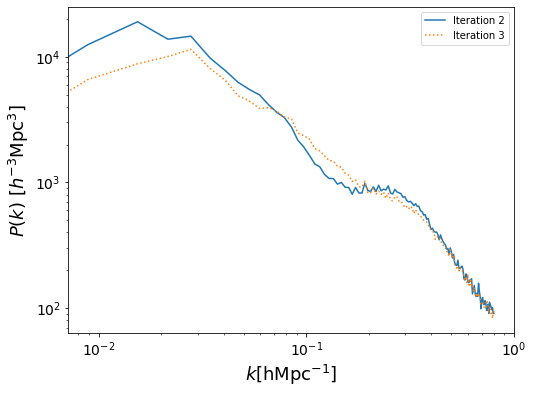

Iteration 3, Mean difference between Pks: 300.69


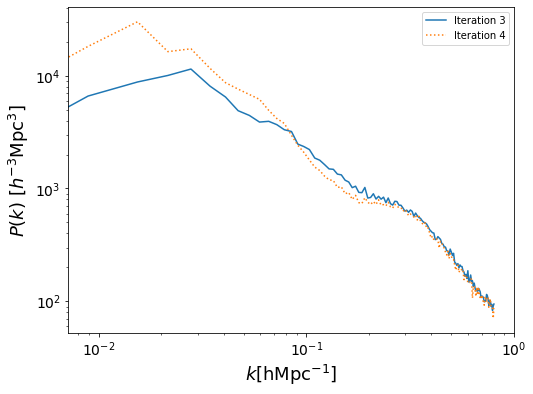

Iteration 4, Mean difference between Pks: 522.80


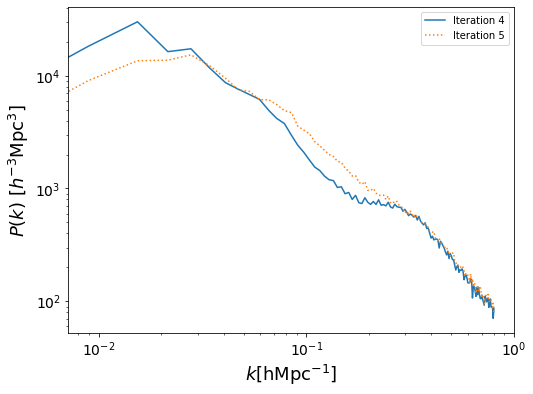

Iteration 5, Mean difference between Pks: 415.42


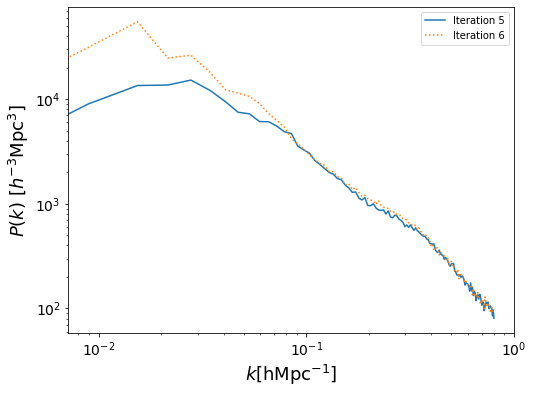

Iteration 6, Mean difference between Pks: 878.14


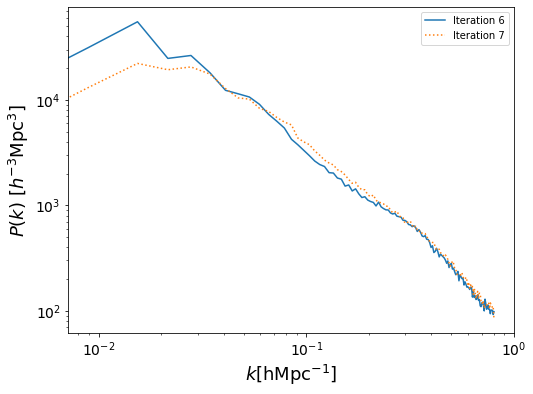

Iteration 7, Mean difference between Pks: 613.51


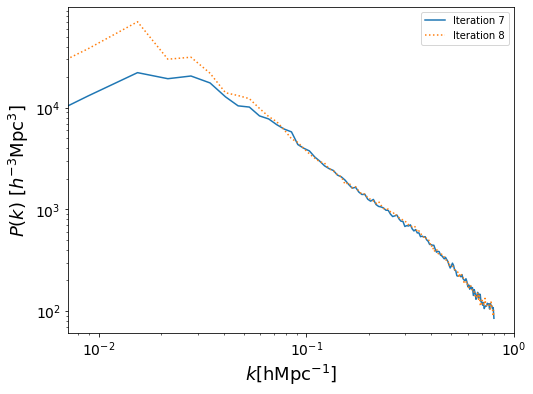

Iteration 8, Mean difference between Pks: 872.20


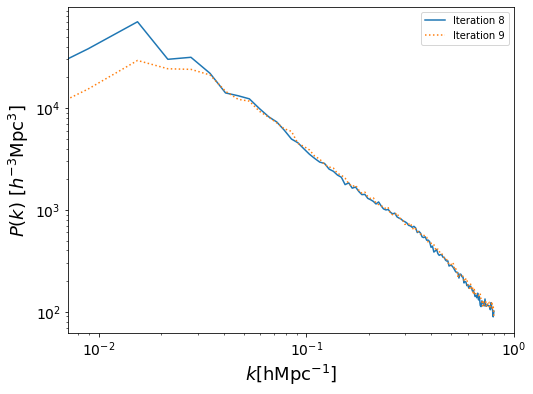

Iteration 9, Mean difference between Pks: 671.58


In [19]:
# From redshift position
iterative_reconstruction(9, Length, Nc, zobs, zinit, galaxy, matter, np.array([Length/2, Length/2, Length/2]))

In [20]:
# Bias in real space
bgreconr2 = evaluate_bias(galaxy, matter, tracer_pos='PositionQ')
bgreconr1 = bgreconr2 * D(zobs)/D(zinit)

print('bias (real) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgreconr1, zinit,bgreconr2, zobs))

# Bias in redshift space
bgrecons2 = evaluate_bias(galaxy, matter, tracer_pos='PositionQS')
bgrecons1 = bgrecons2 * D(zobs)/D(zinit)

print('bias (redshift) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgrecons1, zinit,bgrecons2, zobs))

bias (real) POST= 3.07(z=3.00),1.14(z=0.30)
bias (redshift) POST= 3.20(z=3.00),1.19(z=0.30)


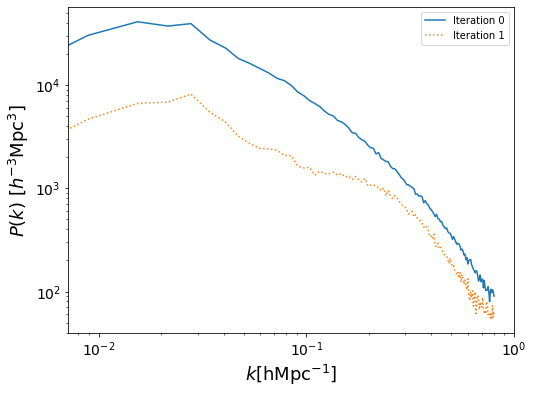

Iteration 1, Mean difference between Pks: 2587.32


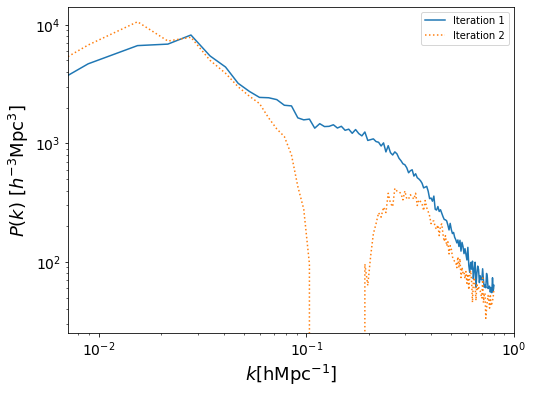

Iteration 2, Mean difference between Pks: 406.21


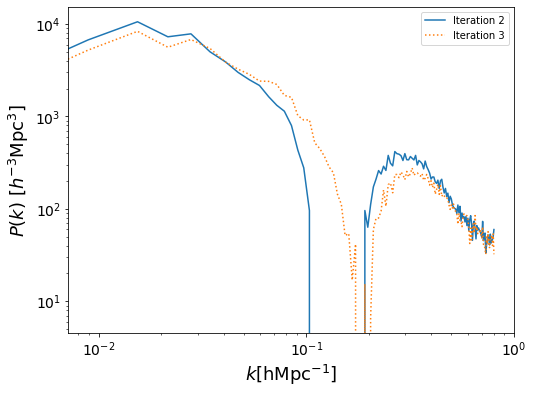

Iteration 3, Mean difference between Pks: 166.78


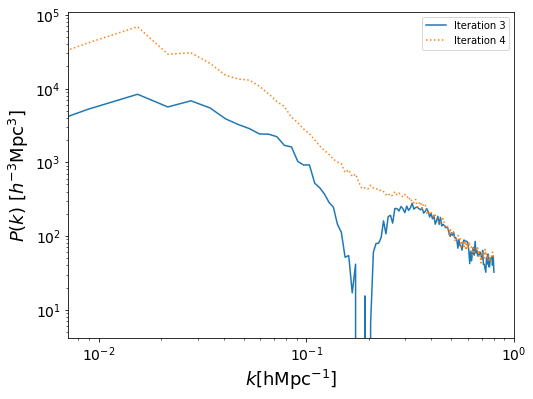

Iteration 4, Mean difference between Pks: 1877.64


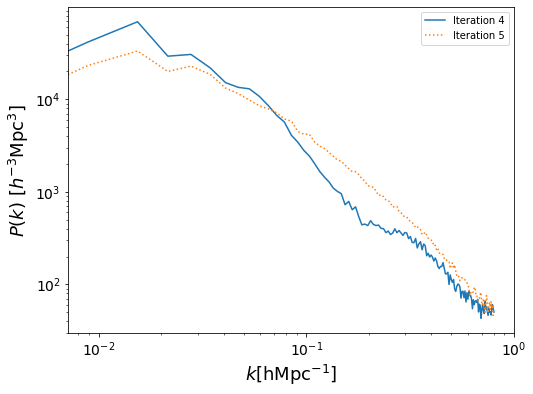

Iteration 5, Mean difference between Pks: 926.31


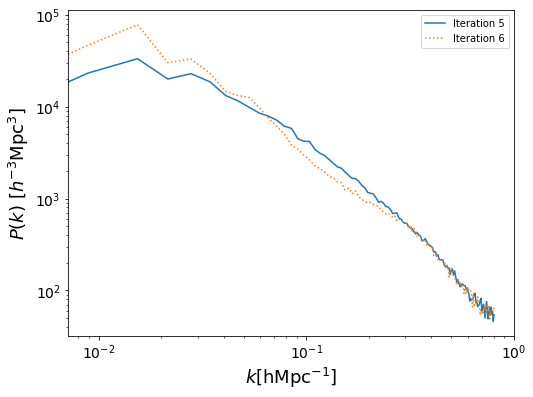

Iteration 6, Mean difference between Pks: 940.27


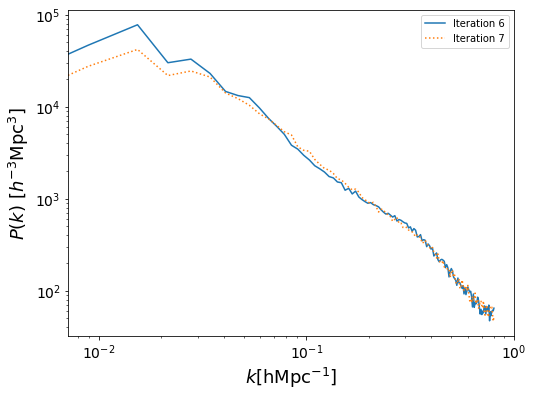

Iteration 7, Mean difference between Pks: 669.08


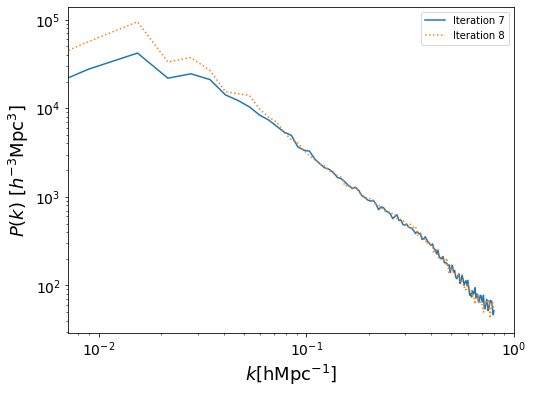

Iteration 8, Mean difference between Pks: 975.87


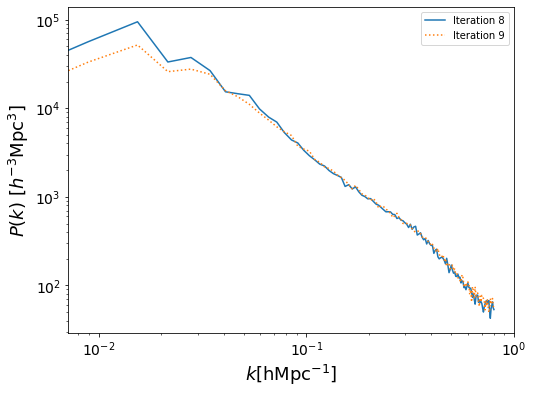

Iteration 9, Mean difference between Pks: 753.36


In [22]:
# From real space position
iterative_reconstruction(9, Length, Nc, zobs, zinit, galaxy, matter, np.array([Length/2, Length/2, Length/2]), real_space=True)

In [23]:
# Bias in real space
bgreconr2 = evaluate_bias(galaxy, matter, tracer_pos='PositionQ')
bgreconr1 = bgreconr2 * D(zobs)/D(zinit)

print('bias (real) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgreconr1, zinit,bgreconr2, zobs))

# Bias in redshift space
bgrecons2 = evaluate_bias(galaxy, matter, tracer_pos='PositionQS')
bgrecons1 = bgrecons2 * D(zobs)/D(zinit)

print('bias (redshift) POST= {:.2f}(z={:.2f}),{:.2f}(z={:.2f})'.format(bgrecons1, zinit,bgrecons2, zobs))

bias (real) POST= 3.02(z=3.00),1.12(z=0.30)
bias (redshift) POST= 2.81(z=3.00),1.04(z=0.30)


Text(0, 0.5, '$P(k) \\, [\\mathrm{h}^3 \\mathrm{Mpc}^{-3}]$')

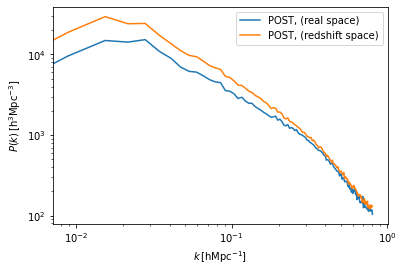

In [11]:
plt.loglog(k, Pkgreconr, label='POST, (real space)')
plt.loglog(k, Pkgrecons, label='POST, (redshift space)')
plt.legend()
plt.xlabel(r'$k \, [\mathrm{h Mpc}^{-1}]$')
plt.ylabel(r'$P(k) \, [\mathrm{h}^3 \mathrm{Mpc}^{-3}]$')